# Auto-MPG dataset  — tree-based regressors

* Use a regression tree to predict the mpg (miles per gallon) consumption of cars using all the six available features.
* Compare the test set RMSE of the regression tree to that achieved by a linear regression model. 
* Diagnose the bias and variance of the regression tree.
* Use Random Forests and hyperparameters' tuning to find the most important features.
* Use Gradient Bossting to find the most important features.
* Use Stochastic Gradient Bossting to find the most important features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append('../data')
    sys.path.append('../src')
    
from plot_features_importance import plot_features_importance


SEED =1

import warnings
warnings.filterwarnings('ignore')


### Read data

In [2]:
df = pd.read_csv("../data/auto_mpg.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     392 non-null    float64
 1   displ   392 non-null    float64
 2   hp      392 non-null    int64  
 3   weight  392 non-null    int64  
 4   accel   392 non-null    float64
 5   origin  392 non-null    object 
 6   size    392 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 21.6+ KB


In [3]:
df.head()

,mpg,displ,hp,weight,accel,origin,size
0,18.0,250.0,88,3139,14.5,US,15.0
1,9.0,304.0,193,4732,18.5,US,20.0
2,36.1,91.0,60,1800,16.4,Asia,10.0
3,18.5,250.0,98,3525,19.0,US,15.0
4,34.3,97.0,78,2188,15.8,Europe,10.0


In [4]:
df["origin"].unique()

array(['US', 'Asia', 'Europe'], dtype=object)

### Convert categorical values to binary

In [5]:
# Creating the dummy variables and removing the original categorical feature from the dataset
df = pd.get_dummies(df)
df.head()

,mpg,displ,hp,weight,accel,size,origin_Asia,origin_Europe,origin_US
0,18.0,250.0,88,3139,14.5,15.0,0,0,1
1,9.0,304.0,193,4732,18.5,20.0,0,0,1
2,36.1,91.0,60,1800,16.4,10.0,1,0,0
3,18.5,250.0,98,3525,19.0,15.0,0,0,1
4,34.3,97.0,78,2188,15.8,10.0,0,1,0


### Split data into training and testing sets


In [6]:
X = df.drop("mpg", axis=1)
y = df["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

### Train a regression tree

In [7]:
dt = DecisionTreeRegressor(max_depth=8,
                           min_samples_leaf=0.13, # each leaf shoudl contain at least 10% of the training data
                           random_state=SEED)


# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))



Test set RMSE of dt: 4.27


### Linear regression vs regression tree

Compare the test set RMSE of dt to that achieved by a linear regression model. 

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict test set labels 
y_pred_lr = lr.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))


Linear Regression test set RMSE: 3.98
Regression Tree test set RMSE: 4.27


### Diagnose bias and variance

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

dt = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf=0.14, # each leaf shoudl contain at least 14% of the training data
                           random_state=123)

MSE_CV = - cross_val_score(dt, X_train, y_train,
                         cv=10, scoring="neg_mean_squared_error",
                         n_jobs = -1)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred_train
y_pred_train = dt.predict(X_train)

# Compute y_pred_test
y_pred_test = dt.predict(X_test)

# CV MSE
print("CV MSE: {:.2f}".format(MSE_CV.mean()))

# Training MSE
print("Train MSE: {:.2f}".format(MSE(y_train, y_pred_train)))

# Test MSE
print("Test MSE: {:.2f}".format(MSE(y_test, y_pred_test)))




CV MSE: 18.41
Train MSE: 14.61
Test MSE: 19.92


### Conclusion: 
The decision tree has overfitted the data because: Train MSE <  CV MSE 

### RF regressor, GridSearch and hyperparameters tuning

In [10]:
rf = RandomForestRegressor(random_state=SEED)
print(rf.get_params())

params_rf = {
    "n_estimators": [300, 400, 500],
    "max_depth": [4, 6, 8],
    "min_samples_leaf": [0.1, 0.2],
    "max_features": ["log2", "sqrt"]
}

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=3,
                       scoring="neg_mean_squared_error",
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams = grid_rf.best_params_
print("Best hyperparameters:\n", best_hyperparams)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best hyperparameters:
 {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 500}


In [11]:
# Extracting the best model
best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

rmse_test=MSE(y_test, y_pred)**(1/2)

print("Test set RMSE of rf: {:.3f}".format(rmse_test))

Test set RMSE of rf: 3.797


### Plot features importance


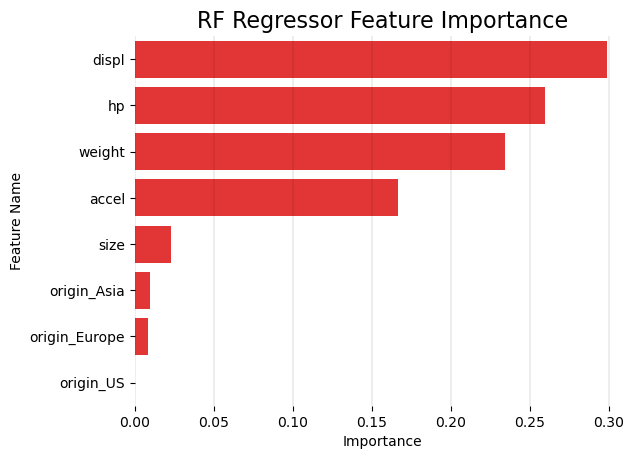

In [12]:
plot_features_importance(best_model.feature_importances_, X_train.columns.to_list(), "RF Regressor Feature Importance")


### Gradient Boosting

In [13]:
gbt = GradientBoostingRegressor(n_estimators=300,
                           max_depth=1,
                           random_state=SEED)

gbt.fit(X_train, y_train)
y_pred=gbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)

print("Test set RMSE of rf: {:.2f}".format(rmse_test))

Test set RMSE of rf: 4.01


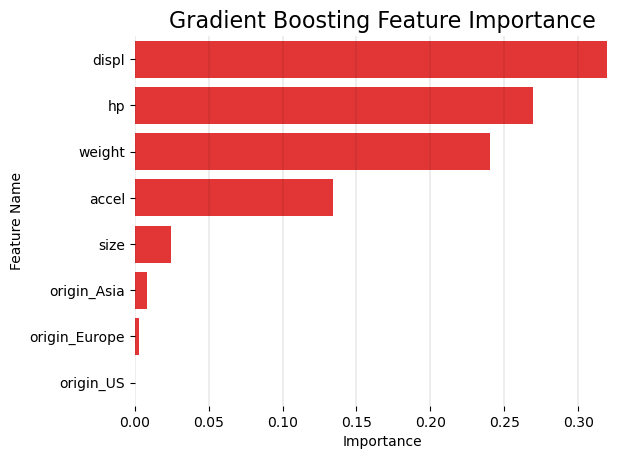

In [14]:
plot_features_importance(gbt.feature_importances_, X_train.columns.to_list(), "Gradient Boosting Feature Importance")


### Stochastic Gradient Boosting

In [15]:
sgbt = GradientBoostingRegressor(max_depth=1,
                                 subsample=0.8,
                                 max_features=0.2,
                                 n_estimators=300,
                                 random_state=SEED)


sgbt.fit(X_train, y_train)
y_pred=sgbt.predict(X_test)


rmse_test = MSE(y_test, y_pred)**(1/2)

print("Test set RMSE of rf: {:.2f}".format(rmse_test))

Test set RMSE of rf: 3.95


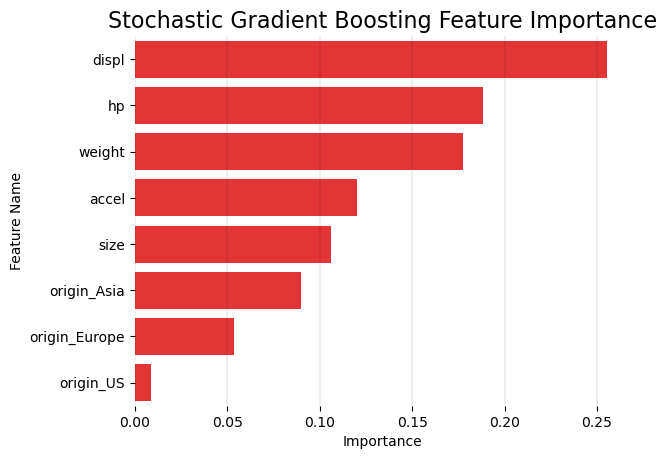

In [16]:
plot_features_importance(sgbt.feature_importances_, X_train.columns.to_list(), "Stochastic Gradient Boosting Feature Importance")
